# Прогнозирование температуры звезды

В данном проекте рассмотрена задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

In [1]:
!python -m pip install skorch

## 1. Загрузка данных

Для начала загрузим все нужные библиотеки, а также добавим "якоря" для того, чтобы результаты при перезапуске тетради не менялись.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from math import sqrt
from math import ceil
from sklearn.compose import ColumnTransformer

torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
np.random.seed(0)

Загрузим датафрейм и посмотрим на данные.

In [3]:
df = pd.read_csv('/datasets/6_class.csv')
df

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


Мы видим лишнюю колонку с индексами, для обучения она не нужна, избавимс от нее.

In [4]:
df = df.drop(columns='Unnamed: 0')
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


Уже сейчас становится понятно, что популяция достаточно небольшая. В помощь модели проведем аугментацию данных - в дальнейшем разделим выборки на тренировочную и обучающую и добавим к существующему тренировочной все те же значения, только несущественно изменим числовые данные.

## 2. Предобработка и анализ данных

Посмотрим, какая информация находится в датасете.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Искомый датасет содержит следующие колонки:
- `Temperature (K)` Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- `Luminosity(L/Lo)` Относительная светимость L/Lo — светимость звезды относительно Солнца.
- `Radius(R/Ro)` Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- `Star type` Тип звезды.
- `Star color` Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Пропущенные значения отсутствуют. Посмотрим на категориальные и числовые данные поближе.

- Категориальные данные

В колонке `Star type` находятся значения от 0 до 5, обозначающие тип звезды:
- `0` Коричневый карлик
- `1` Красный карлик
- `2` Белый карлик
- `3` Звёзды главной последовательности
- `4` Сверхгигант
- `5` Гипергигант

А вот в колонке `Star color` содержатся строковые значения - цвет звезды. Приведем значения этой колонки к строковому формату и посмотрим уникальные значения.

In [6]:
df['Star color'] = df['Star color'].str.lower()
df['Star color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'blue ', 'yellowish',
       'orange-red', 'blue white '], dtype=object)

Мы видим неявные дубликаты из-за лишних пробелов, порядка слов в обозначении цвета и т.д., исправим это с помощью функции.

In [7]:
def star_color(value):
    if value == 'blue ':
        return 'blue'
    elif value == 'blue white ' or value == 'blue white':
        return 'blue-white'
    elif value == 'yellowish white' or value == 'white-yellow' or value == 'yellowish':
        return 'yellow-white'
    else:
        return value
    
df['Star color'] = df['Star color'].apply(star_color)
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'yellow-white', 'pale yellow orange',
       'blue', 'whitish', 'orange', 'orange-red'], dtype=object)

Теперь можно посмотреть состав данных на фоне всего датасета, для этого построим графики.

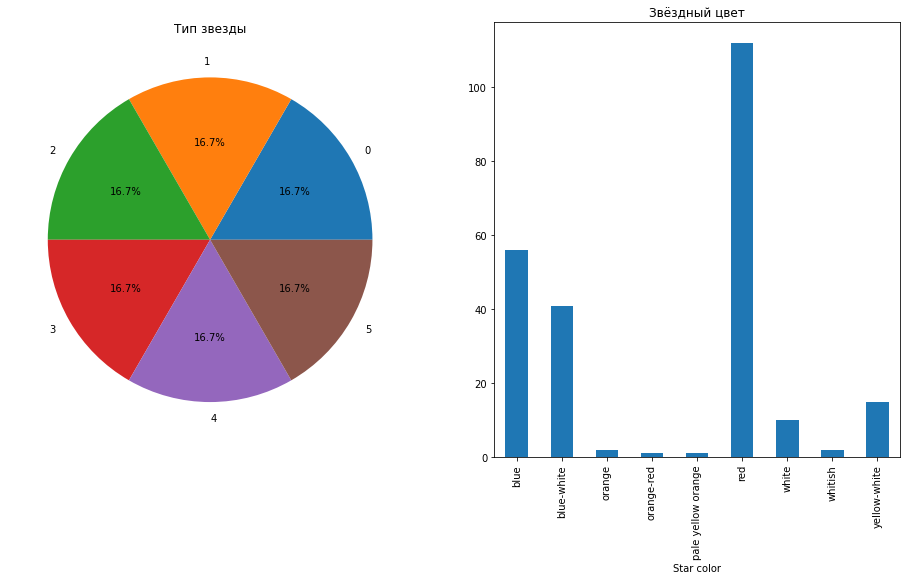

In [8]:
# 1 строка, 2 колонки, 1-ый график
pylab.subplot(1, 2, 1)
df_group = df.groupby('Star type')['Star type'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(16,8))
plt.title('Тип звезды')
plt.ylabel('')

# 1 строка, 2 колонки, 2-ой график
pylab.subplot(1, 2, 2)
df_group = df.groupby('Star color')['Star color'].count()
df_group.plot(kind='bar', figsize=(16,8))
plt.title('Звёздный цвет')
plt.ylabel('')
plt.show()

Типы звезд в предоставленном датасете представлен достаточно разномерно. А вот цвет у цветов звезд наблюдается явный дисбаланс. Посмотрим далее, как с этим справится нейронная сеть. При необходимости проведем аугментацию даннх для редко представленных цветов.

## 3. Построение базовой нейронной сети

Для начала выделим количественные и категориальные признаки.

In [9]:
num = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
cat = ['Star type', 'Star color']

Разделим данные на обучающий и тестовый наборы. Для дальнейшей работы обнулим в получившихся объектах индексы.

In [10]:
features = df.drop('Temperature (K)', axis=1)
target = df['Temperature (K)']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=True, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Теперь мы можем провести аугментацию для обучающей выборки. Подготовим один дополнительный датасет, домножив на `1.01`, и второй датасет, поделив изначальные данные на `1.01`. Данная манипуляция увеличит датасет для обучения в разы, но при этом не будет являться для нейронных сетей той же самой информацией.

Дополним изначальный датасет "увеличенным" и "уменьшенным" по значениям.

In [11]:
X_train

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,672.00000,6.9800,-2.300,3,blue-white
1,0.00087,0.0932,16.880,0,red
2,0.00043,0.0912,17.160,0,red
3,0.00098,0.0911,16.450,0,red
4,813000.00000,14.0000,-6.230,4,blue
...,...,...,...,...,...
175,363000.00000,63.0000,-5.830,4,blue
176,0.00060,0.1400,11.782,1,red
177,0.08500,0.7950,6.228,3,yellow-white
178,248490.00000,1134.5000,-8.240,5,blue-white


In [12]:
X_train_2 = pd.DataFrame()
X_train_2['Luminosity(L/Lo)'] = X_train['Luminosity(L/Lo)'] * 1.01
X_train_2['Radius(R/Ro)'] = X_train['Radius(R/Ro)'] * 1.01
X_train_2['Absolute magnitude(Mv)'] = X_train['Absolute magnitude(Mv)'] * 1.01
X_train_2['Star type'] = X_train['Star type']
X_train_2['Star color'] = X_train['Star color']

X_train_3 = pd.DataFrame()
X_train_3['Luminosity(L/Lo)'] = X_train['Luminosity(L/Lo)'] / 1.01
X_train_3['Radius(R/Ro)'] = X_train['Radius(R/Ro)'] / 1.01
X_train_3['Absolute magnitude(Mv)'] = X_train['Absolute magnitude(Mv)'] / 1.01
X_train_3['Star type'] = X_train['Star type']
X_train_3['Star color'] = X_train['Star color']

display(X_train_2)
display(X_train_3)

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,678.720000,7.049800,-2.32300,3,blue-white
1,0.000879,0.094132,17.04880,0,red
2,0.000434,0.092112,17.33160,0,red
3,0.000990,0.092011,16.61450,0,red
4,821130.000000,14.140000,-6.29230,4,blue
...,...,...,...,...,...
175,366630.000000,63.630000,-5.88830,4,blue
176,0.000606,0.141400,11.89982,1,red
177,0.085850,0.802950,6.29028,3,yellow-white
178,250974.900000,1145.845000,-8.32240,5,blue-white


,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,665.346535,6.910891,-2.277228,3,blue-white
1,0.000861,0.092277,16.712871,0,red
2,0.000426,0.090297,16.990099,0,red
3,0.000970,0.090198,16.287129,0,red
4,804950.495050,13.861386,-6.168317,4,blue
...,...,...,...,...,...
175,359405.940594,62.376238,-5.772277,4,blue
176,0.000594,0.138614,11.665347,1,red
177,0.084158,0.787129,6.166337,3,yellow-white
178,246029.702970,1123.267327,-8.158416,5,blue-white


In [13]:
frames = [X_train, X_train_2, X_train_3]
X_train = pd.concat(frames).reset_index(drop=True)
X_train

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,672.000000,6.980000,-2.300000,3,blue-white
1,0.000870,0.093200,16.880000,0,red
2,0.000430,0.091200,17.160000,0,red
3,0.000980,0.091100,16.450000,0,red
4,813000.000000,14.000000,-6.230000,4,blue
...,...,...,...,...,...
535,359405.940594,62.376238,-5.772277,4,blue
536,0.000594,0.138614,11.665347,1,red
537,0.084158,0.787129,6.166337,3,yellow-white
538,246029.702970,1123.267327,-8.158416,5,blue-white


Также увеличим правильные ответы для модели.

In [14]:
y_train = pd.concat([y_train, y_train, y_train]).reset_index(drop=True)
y_train

0      11250
1       2935
2       3323
3       2817
4      40000
       ...  
535    24630
536     2650
537     4077
538    24490
539    23000
Name: Temperature (K), Length: 540, dtype: int64

С помощью `ColumnTransformer()` проведем преобразование категориальных признаков и масштабирование признаков для популяции для обучения и для тестовой выборки.

In [15]:
col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), num),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

Теперь можно преобразовать данные в формат PyTorch Tensors.

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Поскольку в следующих шагах мы намерены проводить подбор параметров нейронной сети, таких как `dropout` и `размер батча`, создадим для этого отдельные функции. Начнем с функции, в которой определим архитектуру нейронной сети.

Так как по условиям задачи количество слоев и нейронов в них для сравнения результатов не должен меняться, пропишем их явно.

In [17]:
def dropout_p(value):
    
    n_in = X_train.shape[1]
    n_hid_1 = 30
    n_hid_2 = 20
    n_hid_3 = 15
    n_hid_4 = 5
    n_out = 1
    
    net = nn.Sequential(
        nn.Linear(n_in, n_hid_1), nn.ReLU(),
        nn.Linear(n_hid_1, n_hid_2), nn.ReLU(), nn.Dropout(p=value),
        nn.Linear(n_hid_2, n_hid_3), nn.ReLU(), nn.Dropout(p=value),
        nn.Linear(n_hid_3, n_hid_4), nn.ReLU(), nn.Dropout(p=value),
        nn.Linear(n_hid_4, n_out)
    )
    
    return net

Далее определим функцию инициализации весов. С ней мы эксперементировать также не будем, но применим ко всем слоям.

In [18]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') # Веса
        nn.init.uniform_(layer.bias) # Смещение

Теперь мы можем прописать функцию обучения нашей модели так, чтобы можно было запускать ее в цикле перебора параметров. В рамках данного проекта это будут `dropout` и `размер батча`, которые будут попадать в функцию через параметры. Внутри этой функции мы также определим функцию потерь `MSELoss()` и оптимизатор `Adam`.

На выходе у функции будут тестовые предсказания, фактические ответы, а также `RMSE` - метрика каества, данная по заданию. Метрику мы будем использовать далее для определения лучших `dropout` и `размер батча`, а вот тестовые предсказания и фактические ответы пригодятся нам для построения графика лучшего результата.

In [19]:
def model_ch(p, batch_size):

    loss = nn.MSELoss() # Определение функции потерь
    
    net = dropout_p(p)
    net.apply(init_weights)
    
    optimizer = optim.Adam(net.parameters(), lr=0.005) # Определение оптимизатора
    
    accumulation_iteration = 5
    num_batches = ceil(len(X_train)/batch_size)    
    
    num_epochs = 3000
    best_test_rmse = 100000

    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train))
        optimizer.zero_grad()
        
        for batch_i in range(num_batches):
            
            start_index = batch_i * batch_size
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_train).flatten()
            loss_value = loss(preds, y_train)
            loss_value.backward()
            
            if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
                optimizer.step()
                optimizer.zero_grad()

        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            test_rmse = sqrt(loss(test_preds, y_test))

            if test_rmse < best_test_rmse:
                best_test_rmse = test_rmse
            else:
                break

    print()
    print('Batch size:', batch_size)
    print('Dropout:', p)
    rmse = sqrt(loss(preds, y_train))
    print('RMSE train:', rmse)
    test_rmse = sqrt(loss(test_preds, y_test))
    print('RMSE test:', round(test_rmse, 2))
    
    return test_preds, y_test, round(test_rmse,2)

Для наглядности будем выводить результаты `Предсказания/факт` для первых 13 звезд по данным теста. Чтобы не прописывать каждый раз достаточно массивный код для графика, выделим ему отдельную функцию, которую вызовем для результатов до подбора, и лучших результатов после подбора.

In [20]:
def chart(preds, y):
        
    p = np.array(preds[0:13].detach().numpy())
    y = np.array(y[0:13].detach().numpy())
    indexes = np.arange(13)

    sns.set(rc={"figure.figsize":(17, 6)})
    sns.set_style("ticks",{'axes.grid' : True})

    barplot = sns.barplot(x=indexes, y=p, color='#fec000', alpha=0.7, label='Прогноз', zorder=2)
    for bar, width in zip(barplot.patches, [0.4] * len(p)):
        bar.set_width(width)

    barplot = sns.barplot(x=indexes, y=y, color='#ade2f6', alpha=0.9, label='Факт', zorder=1)
    for bar, width in zip(barplot.patches, [0.4] * len(y)):
        bar.set_width(width)
        x = bar.get_x()
        bar.set_x(x+width/2)

    barplot.set_xlabel("Номер звезды в таблице данных", fontweight='bold')
    barplot.set_ylabel("Температура звезды", fontweight='bold')
    barplot.set_title("Температура звезд")

    handles, labels = barplot.get_legend_handles_labels()

    handles[0], handles[1] = handles[1], handles[0]
    labels[0], labels[1] = labels[1], labels[0]

    legend = barplot.legend(handles, labels, bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2)

    legend.get_frame().set_linewidth(0)

По итогу подготовки всех необходимых функций мы можем запустить нашу модель до перебора параметров `dropout` и `размер батча` и посмотреть, какие будут результаты.


Batch size: 540
Dropout: 0.0
RMSE train: 3849.0428680387545
RMSE test: 4469.99


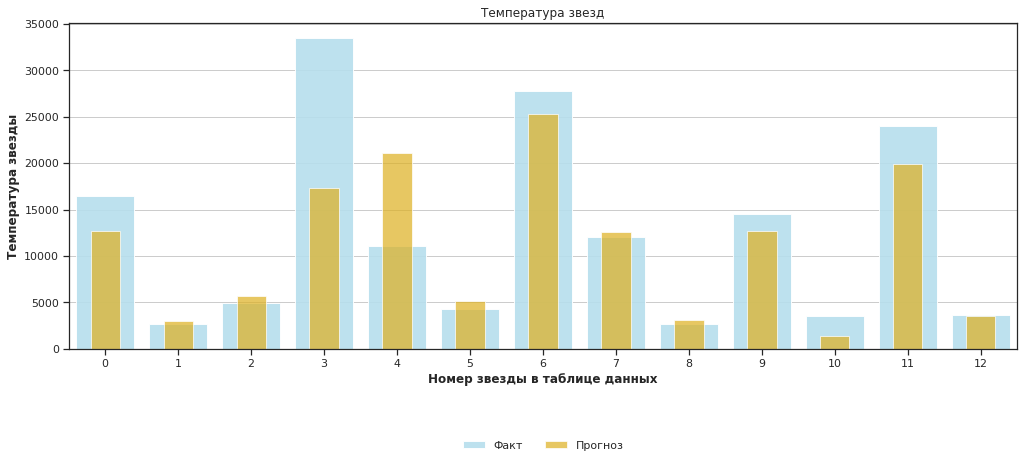

In [21]:
dropout_n = 0.0
batch_size = X_train.shape[0]
test_preds, y_test, rmse = model_ch(dropout_n, batch_size)
chart(test_preds, y_test)

Без применения батчей и dropout модель показывает достаточно хороший результат. График это также наглядно показывает. В целом, мы видим некоторый "недобор" прогноза, особенно у первой звезды графика, но если посмотреть на картину целмком - модель достаточно точно предсказывает температуру на поверхности звезд в Кельвинах.

По задаче нам необходимо получить `RMSE` не более `4 500`, без дополнительных переборов нейросеть показывает `RMSE` в размере `4 469.99`. Посмотрим, как повлияет на модель подбор дополнительных параметров `dropout` и `размер батча`.

## 4. Улучшение нейронной сети

Создадим решение с перебором параметров нейросети - `dropout` и `размер батча`. 
Архитектура нейронной сети: `количество слоёв`, `нейронов`, `вид функции активации` остается как в Baseline, чтобы сравнить результат.

Для параметра `размер батча` выберем размерность в `20, 50, 80, 100 и 150`. Для `dropout` определим параметры `0.1-0.8` с шагом `0.1`. Используя наши функции выше определим наилучшее сочетание `dropout` - `размер батча` по метрике качества `RMSE`. Для наглядности соберем все возможные варианты и их `RMSE` в список, чтобы далее преобразовать его в таблицу и изучить подробнее.

In [22]:
batch_size_list = [20, 50, 80, 100, 150]
dropout_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
best_result = 10000

total_table = []
total_table.append([batch_size, dropout_n, rmse]) # Добавим обучение сети до подборов параметров

for batch_size in batch_size_list:
    for dropout_n in dropout_list:
        test_preds, y_test, rmse = model_ch(dropout_n, batch_size)
        total_table.append([batch_size, dropout_n, rmse]) # Помещаем очередной результат в общий список
        if rmse < best_result:
            best_result = rmse
            best_result_p = dropout_n
            best_result_b = batch_size
            best_preds = test_preds
            best_y = y_test


Batch size: 20
Dropout: 0.1
RMSE train: 3651.8043485378566
RMSE test: 5125.22

Batch size: 20
Dropout: 0.2
RMSE train: 3134.7983986215127
RMSE test: 5177.13

Batch size: 20
Dropout: 0.3
RMSE train: 3627.875411311695
RMSE test: 5238.46

Batch size: 20
Dropout: 0.4
RMSE train: 3637.715354449823
RMSE test: 4906.19

Batch size: 20
Dropout: 0.5
RMSE train: 3434.7772853563592
RMSE test: 5234.34

Batch size: 20
Dropout: 0.6
RMSE train: 3406.5178702011826
RMSE test: 5106.09

Batch size: 20
Dropout: 0.7
RMSE train: 2899.143149277041
RMSE test: 5556.27

Batch size: 20
Dropout: 0.8
RMSE train: 3794.2565806755874
RMSE test: 4708.39

Batch size: 50
Dropout: 0.1
RMSE train: 3950.7238577253156
RMSE test: 4772.31

Batch size: 50
Dropout: 0.2
RMSE train: 3549.8961956654452
RMSE test: 4496.49

Batch size: 50
Dropout: 0.3
RMSE train: 3850.647478022365
RMSE test: 4726.72

Batch size: 50
Dropout: 0.4
RMSE train: 3562.7386937579354
RMSE test: 4731.54

Batch size: 50
Dropout: 0.5
RMSE train: 3931.7759346127

Мы можем проследить за всеми результатами в детализации выше, но в этом нет необходимости, поскольку лучший результат определен, а все подборы собраны в отдельную таблицу. Для начала на график предсказания по параметрам с лушим `RMSE`.

Best RMSE: 4415.95
With best batch_size: 100
With best dropout: 0.4


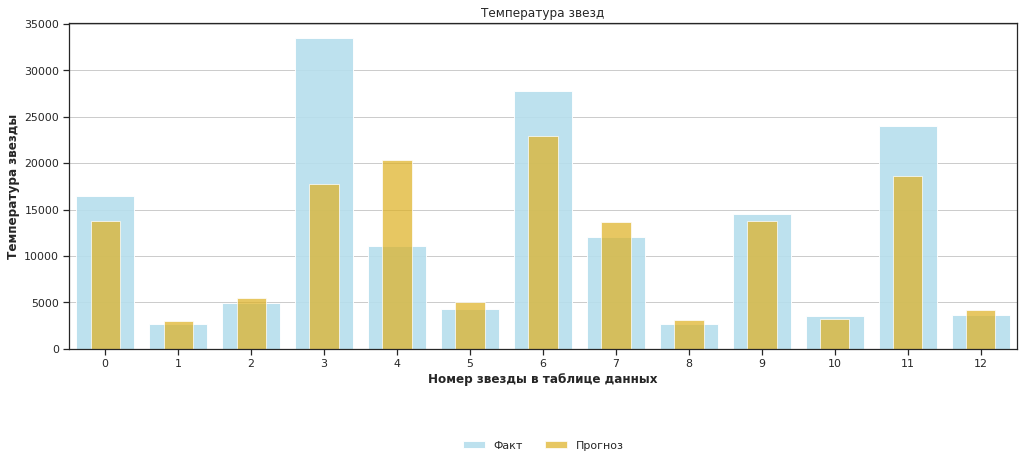

In [23]:
print('Best RMSE:', best_result)
print('With best batch_size:', best_result_b)
print('With best dropout:', best_result_p)

chart(best_preds, best_y)

Мы можем наблюдать повышение точности по сравнению с baseline, который отражен на графике выше. Посмотрим детальнее на общие результаты подбора параметров, предварительно отсортировав по возрастанию `RMSE (test)`.

In [24]:
df_fin = pd.DataFrame(total_table, columns=['Batch size', 'Dropout', 'RMSE (test)'])
df_fin.sort_values(by='RMSE (test)')

,Batch size,Dropout,RMSE (test)
28,100,0.4,4415.95
0,540,0.0,4469.99
10,50,0.2,4496.49
32,100,0.8,4512.13
14,50,0.6,4547.47
40,150,0.8,4555.49
17,80,0.1,4566.88
21,80,0.5,4578.15
13,50,0.5,4611.54
37,150,0.5,4629.86


Таблица получилась достаточно длинной, что затрудняет анализ. Однако, уже сейчас бросается в глаза эффективность работы нейровнных сетей с батчами размером `20`. Они занимают все места в `Топ-5` по лучшим показателям `RMSE` и `70%` в `ТОП-10`. Для более удобного анализа всей картины выведем график.

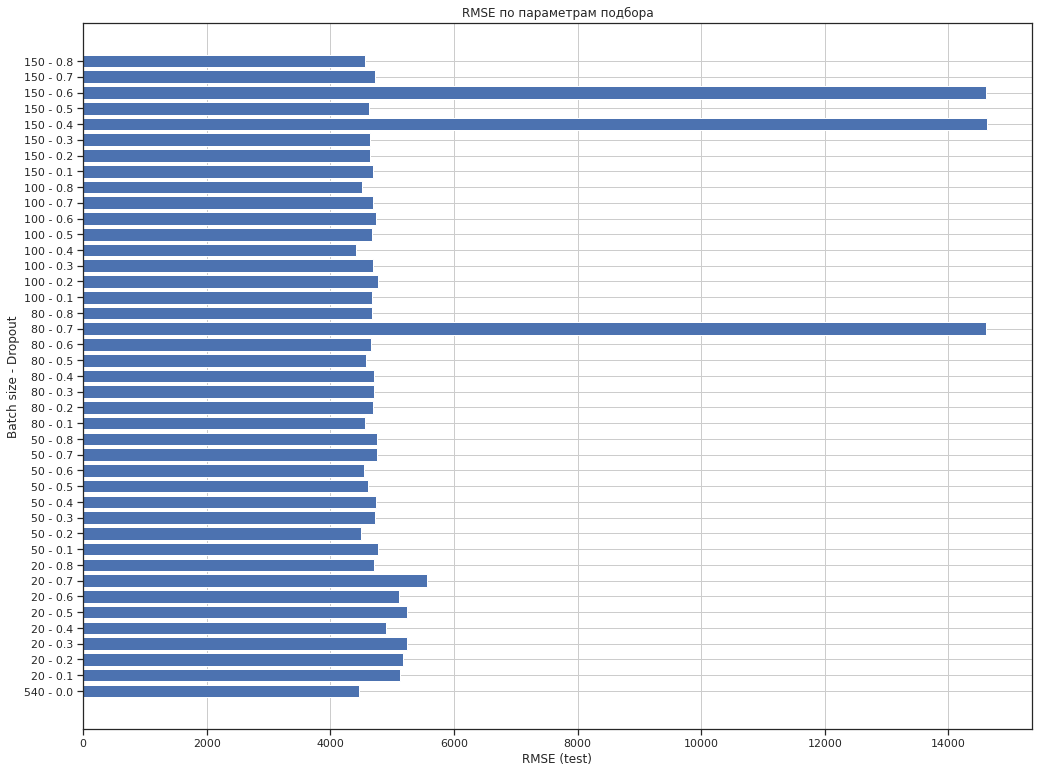

In [25]:
df_fin['Batch size - Dropout'] = df_fin['Batch size'].astype(str) + ' - ' + df_fin['Dropout'].astype(str)

plt.figure(figsize=(17, 13))
plt.barh(df_fin['Batch size - Dropout'], df_fin['RMSE (test)'])
plt.xlabel('RMSE (test)')
plt.ylabel('Batch size - Dropout')
plt.title('RMSE по параметрам подбора')
plt.show()

Здесь уже можно сделать выводы на основании графика целиком. Большинство сочетаний `размер батча` - `dropout` близки к указанному в задаче порогу - `RMSE` ниже `4 500`, но все еще не дотягивают. Наиболее низкие показатели расхождения имеют модели с `100 батчами - dropout 0.4` и `50 батчами - dropout 0.2`. При этом при `150 батчах` мы видим явные проблемы с предсказанием температуры звезд - сразу несколько сочетаний показали аномальные расхождения свыше `14 000`.

Также в данной таблице присутствует информация по результатам обучения нейронной сети без использоания `dropout` и всего на `1 батче` - это первая строка. В целом, результаты удовлетворительные - `4 469.99`. Однако, на фоне использовании подбора сочетаний `размер батча` - `dropout` мы можем сделать вывод, что это принесло некоторую эффективность и показало лучший результат `RMSE` в размере - `4 415.95`. Такой показатель нам дали параметры: `размер батча - 100`, `dropout - 0.4`.

## Выводы

1. По результатам поставленной задачи мы провели анализ и предобработку предоставленной информации для дальнейшего обучения.
2. Мы провели всю необходимую обработку данных, в т.ч. кодирование категориальных данных и масштабирование.
3. Произвели настройку нейронной сети: определили функцию инициализации весов, функцию потерь, оптимизатор и т.д.
4. Обучили baseline без применения `батчей` и `dropout` и наглядно продемонстрировали результаты на графике. Метрика качества `RMSE` на тесте составила `4 469.99`.
5. Перебрали параметры `размер батча` и `dropout` и определили наиболее эффективные для обучения параметры `размер батча - 100`, `dropout - 0.4`, `RMSE` составила `4 415.95`, что несколько лучше, чем у baseline. Визуализировали и проанализировали предсказания и фактическую температуру звезд на тесте с помощью графика.
6. Проанализировали поведение нейронной сети на фоне изменяющихся параметров `размер батча` и `dropout`.